# Predicting online shoppers’ purchasing intention
## Classification using SHAP for feature interpretation and selection
Models tested
* Logistic Regression
* Decision Tree
* Random Forest
* Extra Trees
* AdaBoost
* Gradient Boosting
* XGBoost

**Goal: Understand model predictions and improve model performance using SHAPley values to subset features by importance**

---

Data source:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

SHAP:
https://shap.readthedocs.io/en/latest/index.html


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pprint
import warnings

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
from imblearn.over_sampling import SMOTE  # try for imbalanced classes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

## import custom function to get feature names
from helper import get_feature_names

# datasets to test
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons, make_circles, make_classification

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
# import xgboost as xgb

# metrics
from sklearn.metrics import accuracy_score, auc, classification_report

import shap
shap.initjs()

In [4]:
df = pd.read_csv('../data/online_shoppers_intention.csv')
print(df.shape)
df.head(3)

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


Target variable to predict is **Revenue**

In [5]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [6]:
# df.info()

In [7]:
## No missing vals
# df.isnull().sum()

In [32]:
# class label counts for Revenue
counts = df.iloc[:,-1].value_counts()
print(counts)
n_false = counts.iloc[0]
n_true = counts.iloc[1]
total = n_false + n_true
print(f"{round(n_false / total, 2) * 100}% False") 
print(f"{round(n_true / total, 2) * 100}% True")

0    10422
1     1908
Name: Revenue, dtype: int64
85.0% False
15.0% True


In [9]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


# Data Cleaning:
1. Encoding categorical or boolean variables

In [10]:
## encode target variable
labeler = LabelEncoder()
df['Revenue'] = labeler.fit_transform(df['Revenue'])
# df['Revenue'].value_counts()

In [11]:
cat_cols = list(df.select_dtypes(include=['object', 'bool']).columns)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# num_cols = num_cols0[:-1]
print(cat_cols)
print(num_cols)

['Month', 'VisitorType', 'Weekend']
Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Revenue'],
      dtype='object')


In [12]:
## Transform pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols),
    ("categorical", OneHotEncoder(), cat_cols)
])

In [13]:
arr = pipeline.fit_transform(df)  
print(arr.shape) 

(12330, 30)


In [29]:
feature_names = get_feature_names(pipeline)
print(len(feature_names))
feature_names2 = [x for x in feature_names if x != 'numerical__Revenue']

30


Transformer imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available


In [15]:
# feature_names  

## Fix class imbalance with SMOTE

In [23]:
# transformed df
df2 = pd.DataFrame(arr, columns=feature_names)
df2.shape

(12330, 30)

In [25]:
# define X and Y
# n_features = arr.shape[1]
# X = arr[:, : n_features - 2]
# y = arr[:, -1:]

X = df2.drop(['numerical__Revenue'], axis=1)
y = df2['numerical__Revenue']

## SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

y = y.ravel()
print(X.shape, y.shape)

(20844, 29) (20844,)


In [26]:
## Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13965, 29) (6879, 29) (13965,) (6879,)


In [27]:
# Create classifiers
lr = LogisticRegression(solver='liblinear')  
# gnb = GaussianNB()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()

In [34]:
# Cross validation calculate scores
# models = [lr, dtc, rfc, etc]
models = [lr, dtc, rfc, etc, abc, gbc]
for model in models:
    print('Fitting Model:\n', model)
    scores = cross_val_score(model, X_train, y_train)
    print("Mean Score: ", np.round(scores.mean(), 4))
    print("\n")

Fitting Model:
 LogisticRegression(solver='liblinear')
Mean Score:  0.8334


Fitting Model:
 DecisionTreeClassifier()
Mean Score:  0.908


Fitting Model:
 RandomForestClassifier()
Mean Score:  0.9402


Fitting Model:
 ExtraTreesClassifier()
Mean Score:  0.9419


Fitting Model:
 AdaBoostClassifier()
Mean Score:  0.9263


Fitting Model:
 GradientBoostingClassifier()
Mean Score:  0.9326




Best model: ET has 0.9409 acc

* Can we make the models better by hyperparameter tuning (eg like a randomized grid search)? 
* Can the models be improved by subselecting features based on SHAP importance?

### Random Forest Classifier 
with randomized grid search for tuning hyperparams and finding optimal model

In [35]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
# rfc.fit(X_train, y_train)
# y_pred = rfc.predict(X_test)
# acc = accuracy_score(y_test, y_pred)
# print("accuracy: ", acc)  # accuracy:  0.8145

In [36]:
# what possible params to tune
# pprint.pprint(rfc.get_params())

In [37]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Random search of parameters, using cross validation, use all cores
rf_rand = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

In [38]:
# Fit the random search model
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400,
                                                         1600]},
                   random_state=0, verbose=2)

In [39]:
# print results of rand grid search
best_params = rf_rand.best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

In [40]:
## Random Forest new (optimized from results of grid search)

# rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=0)
rfc = RandomForestClassifier(**best_params)

rfc.fit(X_train,y_train)  # fit the model to the training data

RandomForestClassifier(n_estimators=200)

In [41]:
## Get CV score
score = cross_val_score(rfc, X_train, y_train)
print(np.round(score.mean(), 4))

0.9405


## SHAP visuals 

To show feature contributions to the model output (magnitude, postiive or negative class, num of samples, ...)


Types of plots
* Force Plot
* Bar Plot
* Beeswarm Plot / Scatter Plot
* Waterfall Plot (for indiv preds)

In [43]:
## Take smaller samples for visualization
X_train_sample = shap.utils.sample(X_train, nsamples=50, random_state=0)
X_test_sample = shap.utils.sample(X_test, nsamples=50, random_state=0)

## Kernel Explainer

In [58]:
# explain predictions of model on test set
explainer = shap.KernelExplainer(rfc.predict_proba, X_train_sample)

# compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

In [59]:
# Force Plot
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

Force plot:
    
* The horizontal/X-axis at the top represents the sample number. We have 100 samples in this visual.
* The two colors represent the two class labels (default or no default)

## Tree Explainer

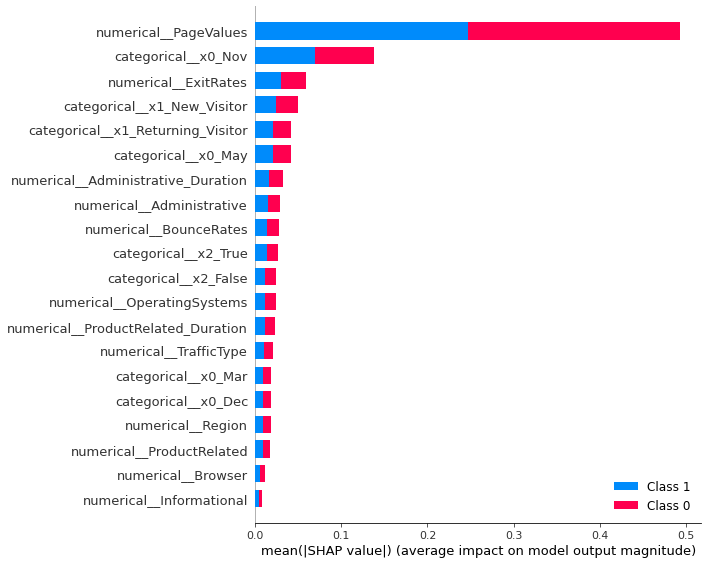

In [44]:
## Bar Plot 
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test_sample)
shap.summary_plot(shap_values, (X_test_sample))

Bar Plot:

creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

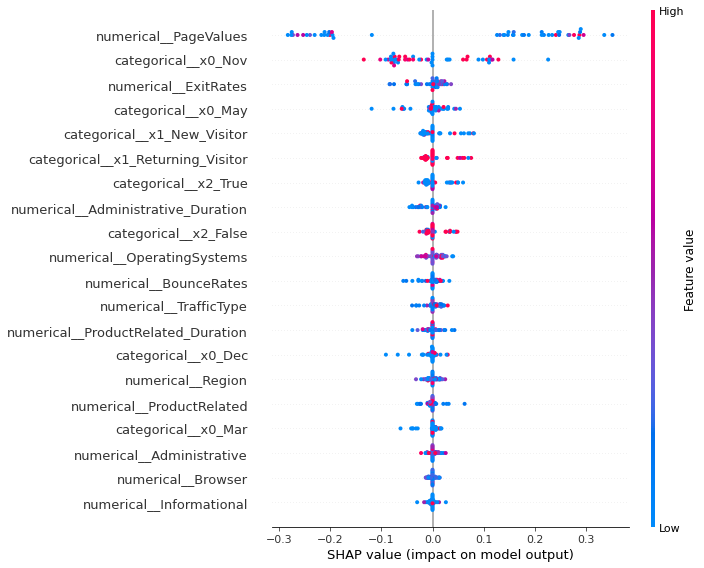

In [61]:
# index [1] represents class label 1
shap.summary_plot(shap_values[1], X_train_sample)

In [81]:
# # Waterfall plot
# ## Designed for INDIVIDUAL preds
# shap.plots.waterfall(shap_values[0])

shap_values is a list of 2 arrays, representing class labels 0 and 1.

Both arrays have 50 observations and 29 features.

In [98]:
len(shap_values)

shap_values[0].shape
shap_values[1].shape


## First observation for class label 0, shows the SHAP values for the observation
shap_values[0][0,:]

top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

In [102]:
top_inds[0]

array([ 8, 28, 27, 20, 10, 24, 11,  7,  0,  5, 12, 19,  4, 13,  6,  2,  9,
       26, 25,  1, 23, 22, 18, 17, 16, 15,  3, 21, 14], dtype=int64)

In [101]:
for i, col in enumerate(X_train_sample.columns):
    print(col, i)

numerical__Administrative 0
numerical__Administrative_Duration 1
numerical__Informational 2
numerical__Informational_Duration 3
numerical__ProductRelated 4
numerical__ProductRelated_Duration 5
numerical__BounceRates 6
numerical__ExitRates 7
numerical__PageValues 8
numerical__SpecialDay 9
numerical__OperatingSystems 10
numerical__Browser 11
numerical__Region 12
numerical__TrafficType 13
categorical__x0_Aug 14
categorical__x0_Dec 15
categorical__x0_Feb 16
categorical__x0_Jul 17
categorical__x0_June 18
categorical__x0_Mar 19
categorical__x0_May 20
categorical__x0_Nov 21
categorical__x0_Oct 22
categorical__x0_Sep 23
categorical__x1_New_Visitor 24
categorical__x1_Other 25
categorical__x1_Returning_Visitor 26
categorical__x2_False 27
categorical__x2_True 28


To try dropping:

    * Month (categorical variable)
    
    * Informational Duration
    
    * Administrative Duration